<a href="https://colab.research.google.com/github/JosseArturo/CarND-Traffic-Sign-Classifier-Project/blob/master/Traffic_Sign_Classifier_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load  Data
Loading from Google Drive through Colab


In [49]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
####################################
#Load data module
#Please select the right path where the data would be storage
####################################

# Load pickled data
import pickle
import numpy as np
import csv

#Path where the training and testing data is

training_file = '/content/drive/My Drive/Traffic-Sign-Classifier/Traffic-Sign-Classifier/Data/train.p' 
validation_file = '/content/drive/My Drive/Traffic-Sign-Classifier/Traffic-Sign-Classifier/Data/valid.p'
testing_file = '/content/drive/My Drive/Traffic-Sign-Classifier/Traffic-Sign-Classifier/Data/test.p' 
signnames_file= '/content/drive/My Drive/Traffic-Sign-Classifier/Traffic-Sign-Classifier/Data/signnames.csv'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

#Assign the labels

all_labels = []
with open(signnames_file, mode='r') as csvfile:
    names = csv.reader(csvfile, delimiter=',')
    for row in names:
        all_labels += [row[1]]
    all_labels=all_labels[1:]
    
print(all_labels)
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing for vehicles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vehicles over 3.5 metric tons']


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. 
**THE ORIGINAL IMAGE IS 32 by 32**


In [52]:
#Number of training examples
n_train = len(X_train)

#Number of testing examples.
n_test = len(X_test)

#Shape of the image
image_shape = X_train[0].shape

#Unique classes/labels the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


###Exploratory visualization of the dataset

In this module we can see the distribution of training samples in the Data set


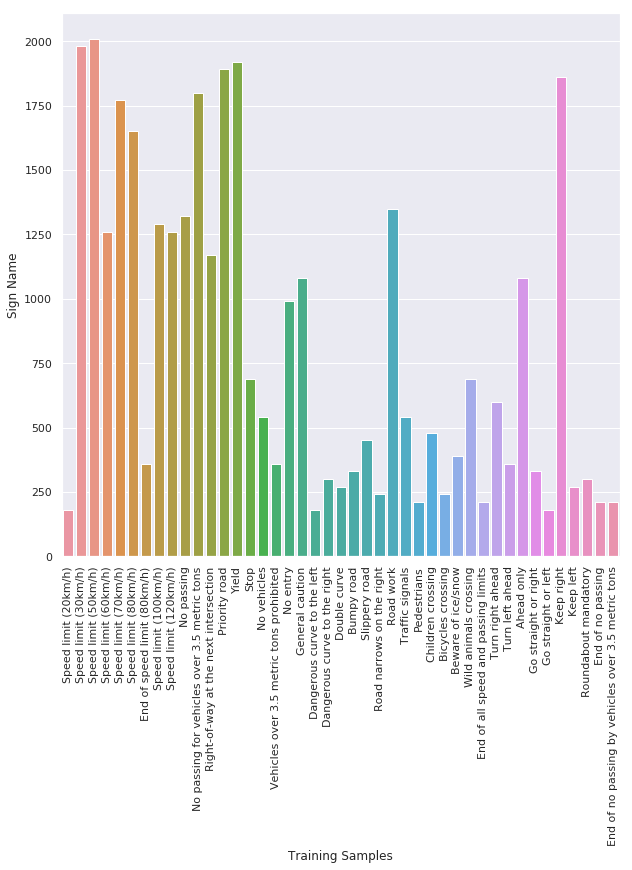

In [53]:
#### Data exploration visualization
##The number of the sampler by class will be plotted
import seaborn as sns
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.

%matplotlib inline

plt.figure(figsize=(10,10))
sns.set(style="darkgrid")
ax = sns.countplot(x=y_train)
plt.ylabel('Sign Name')
plt.xlabel('Training Samples');
plt.xticks(range(n_classes), all_labels,rotation=90 )
plt.savefig('/content/drive/My Drive/Traffic-Sign-Classifier/Traffic-Sign-Classifier/training_set_counts.png')


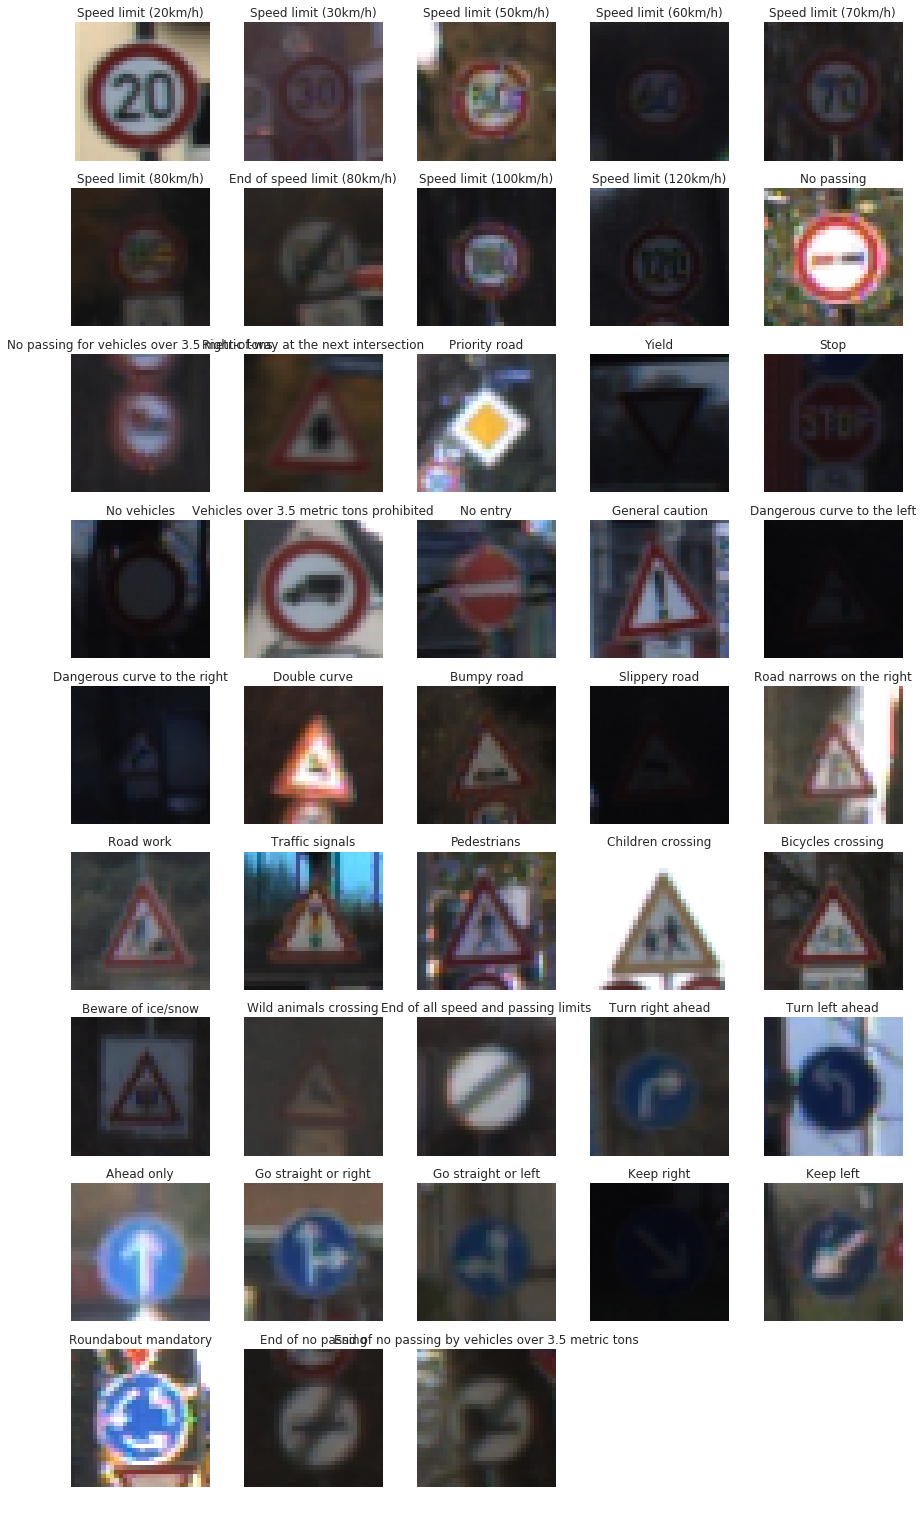

In [54]:
#Plotting all the traffic sign to see the quality of the input images

num_of_samples=[]
plt.figure(figsize=(15, 30))
for i in range(0, n_classes):
    plt.subplot(10, 5, i+1)
    x_selected = X_train[y_train == i]
    plt.imshow(x_selected[0, :, :, :]) #plot the first image of each class
    plt.title(all_labels[i])
    plt.axis('off')
    num_of_samples.append(len(x_selected))
    
plt.show()

----

## Step 2:Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

This model is based on the LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81).
The modification will be explained below.


### Pre-process the Data Set (normalization, grayscale, etc.)
The image data should be normalized so that the data has mean zero and equal variance. 
For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Another pre-processing steps were tried to avoid in order to explore the architecture with the original data set. In this process a new convolutional layer was added and the last fully connected layer was removed

In [55]:
from sklearn.utils import shuffle

print(np.mean(X_train))
print(np.mean(X_test))

## Data normalization

X_train_n = (X_train.astype(np.float32) - 128) / 128
X_test_n = (X_test.astype(np.float32) - 128)/128

print(np.mean(X_train_n))
print(np.mean(X_test_n))

#Original vector
X_train, y_train = shuffle(X_train, y_train)


82.6775890369964
82.14846036120183
-0.35408133
-0.35821554


### Model Architecture

In [0]:
##Define some important variables to tune and explore
import tensorflow as tf
#In case to need to reset the session
#tf.reset_default_graph()

#Number of epochs
EPOCHS = 70
#Size of the batch
BATCH_SIZE = 32

In [57]:
from tensorflow.contrib.layers import flatten
sess = tf.InteractiveSession()
tf.reset_default_graph()
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    ####Layer 1: Convolutional. Input = 32x32x3. Output = 30x30x32.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 3, 32), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(32))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID',name='convolution1') + conv1_b
    print("layer 1 shape:",conv1.get_shape())
    
    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)


    ####Layer 2: Convolutional. Output = 28x28x32.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 32), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    print("layer 2 shape:",conv2.get_shape())
    
    #Activation.
    conv2 = tf.nn.relu(conv2)
    #Pooling. Input = 28x28x32. Output = 14x14x32.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID',name='convolution2')
    print("layer 2 shape:",conv2.get_shape())
    
    ####Layer 3: Convolutional. Output = 12x12x32.
    conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 32), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(32))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    print("layer 3 shape:",conv3.get_shape())
    
    #Activation.
    conv3 = tf.nn.relu(conv3)
    #Pooling. Input = 12x12x16. Output = 6x6x32.
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='convolution3')
    print("layer 3 shape:",conv3.get_shape())
    
    ###Flatten. Input = 6x6x32. Output = 1152.
    fc0   = flatten(conv3)
    
    ####Layer 4: Fully Connected. Input = 1152. Output = 64.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1152, 64), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(64))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    print("layer 4 FC shape:",fc1.get_shape())
    
    #Activation.
    fc1    = tf.nn.relu(fc1)
    
    #Dropout.
    fc1 = tf.nn.dropout(fc1, keep_prob)

    ####Layer 5: Fully Connected. Input =64  Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(64, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc1, fc3_W) + fc3_b
    print("Layer 5  FC shape:",logits.get_shape())
    
    return logits


/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [0]:
##Define Placeholder for the tensor flow session
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32) # probability to keep units

## Training Pipeline
Create a training pipeline that uses the model to classify MNIST data.


In [59]:
##The rate is defined
rate = 0.0005

##The use of the model is set
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

layer 1 shape: (?, 30, 30, 32)
layer 2 shape: (?, 28, 28, 32)
layer 2 shape: (?, 14, 14, 32)
layer 3 shape: (?, 12, 12, 32)
layer 3 shape: (?, 6, 6, 32)
layer 4 FC shape: (?, 64)
Layer 5  FC shape: (?, 43)


##Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.


In [0]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy,loss = sess.run([accuracy_operation,loss_operation], feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
    return total_accuracy / num_examples, total_loss/num_examples

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.


Training...

EPOCH 1 ...
Validation Accuracy = 0.271

EPOCH 2 ...
Validation Accuracy = 0.407

EPOCH 3 ...
Validation Accuracy = 0.583

EPOCH 4 ...
Validation Accuracy = 0.751

EPOCH 5 ...
Validation Accuracy = 0.827

EPOCH 6 ...
Validation Accuracy = 0.867

EPOCH 7 ...
Validation Accuracy = 0.904

EPOCH 8 ...
Validation Accuracy = 0.924

EPOCH 9 ...
Validation Accuracy = 0.930

EPOCH 10 ...
Validation Accuracy = 0.944

EPOCH 11 ...
Validation Accuracy = 0.927

EPOCH 12 ...
Validation Accuracy = 0.953

EPOCH 13 ...
Validation Accuracy = 0.943

EPOCH 14 ...
Validation Accuracy = 0.955

EPOCH 15 ...
Validation Accuracy = 0.962

EPOCH 16 ...
Validation Accuracy = 0.954

EPOCH 17 ...
Validation Accuracy = 0.960

EPOCH 18 ...
Validation Accuracy = 0.961

EPOCH 19 ...
Validation Accuracy = 0.967

EPOCH 20 ...
Validation Accuracy = 0.958

EPOCH 21 ...
Validation Accuracy = 0.961

EPOCH 22 ...
Validation Accuracy = 0.964

EPOCH 23 ...
Validation Accuracy = 0.967

EPOCH 24 ...
Validation Accura

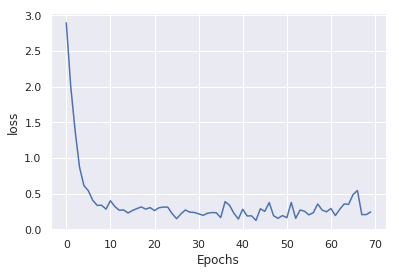

Model saved


In [61]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    loss_accuracy_a=[]
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.75})
            
        validation_accuracy,loss_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        loss_accuracy_a.append(loss_accuracy)
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    plt.plot(range(0,EPOCHS),loss_accuracy_a)
    plt.ylabel('loss')
    plt.xlabel('Epochs')
    plt.grid(True)
    plt.show()    
    saver.save(sess, "/content/drive/My Drive/Traffic-Sign-Classifier/Traffic-Sign-Classifier/trained/last_test2/lenet")
    print("Model saved")

## Importing trained model from Drive

In [0]:
import os
import matplotlib.image as mpimg
saved_data = os.listdir("/content/drive/My Drive/Traffic-Sign-Classifier/Traffic-Sign-Classifier/trained/last_test2/")

In [63]:
print(saved_data)

['Old', '.ipynb_checkpoints', 'lenet.data-00000-of-00001', 'lenet.index', 'checkpoint', 'lenet.meta']


## Evaluate the Model

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.

You do not need to modify this section.

In [64]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('/content/drive/My Drive/Traffic-Sign-Classifier/Traffic-Sign-Classifier/trained/last_test2/lenet.meta')
    saver2.restore(sess, "/content/drive/My Drive/Traffic-Sign-Classifier/Traffic-Sign-Classifier/trained/last_test2/lenet")
   
    train_accuracy = evaluate(X_train, y_train)
    valid_accuracy = evaluate(X_valid, y_valid)
    test_accuracy = evaluate(X_test, y_test)
    print("Train Set Accuracy = {:.3f}".format(train_accuracy[0]))
    print("Validation Set Accuracy = {:.3f}".format(valid_accuracy[0]))
    print("Test Set Accuracy = {:.3f}".format(test_accuracy[0]))
    
    

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Traffic-Sign-Classifier/Traffic-Sign-Classifier/trained/last_test2/lenet
Train Set Accuracy = 0.999
Validation Set Accuracy = 0.975
Test Set Accuracy = 0.966


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

['60_kmh.jpg', 'stop_sign.jpg', 'road_work.jpg', 'left_turn.jpeg', 'yield_sign.jpg']


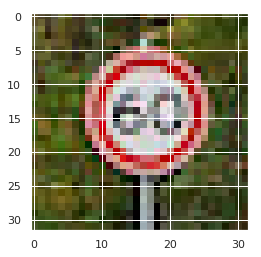

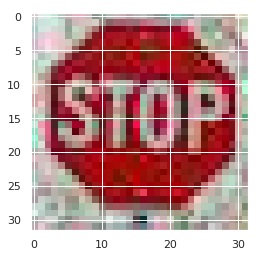

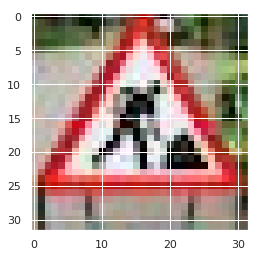

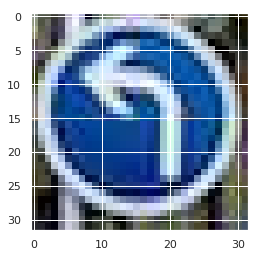

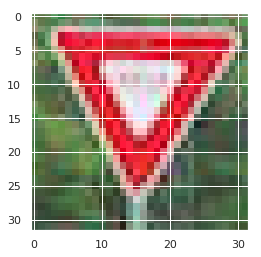

In [65]:
import os
import matplotlib.image as mpimg

##Load the new 5 images
#Please remember change the path
new_images = os.listdir("/content/drive/My Drive/Traffic-Sign-Classifier/Traffic-Sign-Classifier/Data/New/")
print(new_images)

# Show the images, add to a list to process for classifying
new_images_data = []
for i in new_images:
    i = '/content/drive/My Drive/Traffic-Sign-Classifier/Traffic-Sign-Classifier/Data/New/' + i
    image = mpimg.imread(i)
    new_images_data.append(image)
    plt.imshow(image)
    plt.show()

In [66]:

# Make into numpy array
new_images_data = np.array(new_images_data)

print(np.mean(new_images_data))

## Normalization
# new_images_data = (new_images_data.astype(np.float32) - 128)/128

print(np.mean(new_images_data))
print(new_images_data.shape)

113.0794921875
113.0794921875
(5, 32, 32, 3)


### Predict the Sign Type for Each Image. Analyze Performance

In [67]:
my_labels = [3, 14, 35, 34, 13]

with tf.Session() as sess:
    #saver2 = tf.train.import_meta_graph('/content/drive/My Drive/Traffic-Sign-Classifier/Traffic-Sign-Classifier/trained/last_test2/lenet.meta')
    saver2.restore(sess, "/content/drive/My Drive/Traffic-Sign-Classifier/Traffic-Sign-Classifier/trained/last_test2/lenet")
   
    test_accuracy = evaluate(new_images_data, my_labels)
    print("Test Accuracy = {:.3f}".format(test_accuracy[0]))


INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Traffic-Sign-Classifier/Traffic-Sign-Classifier/trained/last_test2/lenet
Test Accuracy = 0.800


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.


In [68]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 

softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=5)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2.restore(sess, "/content/drive/My Drive/Traffic-Sign-Classifier/Traffic-Sign-Classifier/trained/last_test2/lenet")
       
    new_softmax = sess.run(softmax_logits, feed_dict={x: new_images_data, keep_prob: 1.0})
    new_top_k = sess.run(top_k, feed_dict={x: new_images_data, keep_prob: 1.0})
    
    for x in range(len(new_images)):
        print("{0}:".format(new_images[x]))
        for y in range(5):
            print("{:s}: {:.2f}%".format(all_labels[new_top_k[1][x][y]], new_top_k[0][x][y]*100))
        print()
    print(new_softmax)
    print(new_top_k)

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Traffic-Sign-Classifier/Traffic-Sign-Classifier/trained/last_test2/lenet
60_kmh.jpg:
Speed limit (60km/h): 100.00%
No passing: 0.00%
No passing for vehicles over 3.5 metric tons: 0.00%
Ahead only: 0.00%
Speed limit (50km/h): 0.00%

stop_sign.jpg:
Stop: 100.00%
Speed limit (20km/h): 0.00%
Speed limit (30km/h): 0.00%
Speed limit (50km/h): 0.00%
Speed limit (60km/h): 0.00%

road_work.jpg:
Road work: 100.00%
General caution: 0.00%
Speed limit (30km/h): 0.00%
Traffic signals: 0.00%
Bicycles crossing: 0.00%

left_turn.jpeg:
Turn left ahead: 100.00%
Keep right: 0.00%
Speed limit (20km/h): 0.00%
Speed limit (30km/h): 0.00%
Speed limit (50km/h): 0.00%

yield_sign.jpg:
Yield: 100.00%
Priority road: 0.00%
Speed limit (60km/h): 0.00%
No passing: 0.00%
No entry: 0.00%

[[0.0000000e+00 0.0000000e+00 4.9825431e-25 1.0000000e+00 0.0000000e+00
  2.6741501e-29 0.0000000e+00 0.0000000e+00 0.0000000e+00 8.5638072e-15
  5.6778517e-21 0.00000